In [1]:
#Preliminary Steps:

import pandas as pd # we rename pandas for convenience as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf # import this function from this submodule
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
import scipy.signal as ss
import pylab
import seaborn as sns
from scipy.stats import pearsonr, probplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Morgan Stanley's colors
MS_colors = { 'blue': '#0072CE',  'light_blue': '#0072CE',  'navy': '#003B70', 'grey': '#B1B3B3', 'white': '#FFFFFF'}


In [2]:
# Load Morgan Stanley Data

MorganStanley = yf.download("MS", start="1993-02-23", end="2024-12-31", auto_adjust=False)
MorganStanley


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MS,MS,MS,MS,MS,MS
Date,,,,,,
1993-02-23,3.464322,7.750000,8.125000,7.656250,8.000000,40594800
1993-02-24,3.562105,7.968750,8.062500,7.781250,7.875000,9426400
1993-02-25,3.645920,8.156250,8.156250,7.968750,8.000000,5229200
1993-02-26,3.701797,8.281250,8.281250,8.031250,8.156250,2761200
1993-03-01,3.576075,8.000000,8.218750,8.000000,8.187500,3014400
...,...,...,...,...,...,...
2024-12-23,121.060181,124.449997,124.669998,122.790001,123.099998,5074100
2024-12-24,123.599083,127.059998,127.220001,124.589996,125.070000,2902800


In [3]:
Pt_d = MorganStanley["Close"]
Pt_d = Pt_d.rename(columns={Pt_d.columns[0]: "Pt.d"})
Pt_d.index = pd.to_datetime(Pt_d.index)
Pt_d.head()

Ticker,Pt.d
Date,
1993-02-23,7.75000
1993-02-24,7.96875
1993-02-25,8.15625
1993-02-26,8.28125
1993-03-01,8.00000


In [4]:
#Length of the sample
n_days = len(Pt_d)
print("Number of days :", n_days)
n_months = Pt_d.index.to_period('M').nunique()
print("Number of months :", n_months)
n_years = Pt_d.index.year.nunique()
print("Number of years :", n_years)

Number of days : 8021
Number of months : 383
Number of years : 32


In [5]:
# We compute the log prices
pt_d = np.log(Pt_d).squeeze("columns") # we squeeze the column to create a Pandas Series to meet the Numpy/Pandas's requirements later
pt_w = pt_d.resample('W').last()
pt_m = pt_d.resample('ME').last()
pt_y = pt_d.resample('YE').last()

pt_d.name = "pt.d"
pt_w.name = "pt.w"
pt_m.name = "pt.m"
pt_y.name = "pt.y"


In [6]:
#Log returns, We compute log-returns for our sample:
rt_d = pt_d.diff().dropna()
rt_d.name = "rt.d"

rt_w = pt_w.diff().dropna()
rt_w.name = "rt.w.all"

rt_m = pt_m.diff().dropna()
rt_m.name = "rt.m"

rt_y = pt_y.diff().dropna()
rt_y.name = "rt.y."


In [7]:
# Plot of the table
# X contains returns at different frequencies
X = {'daily': rt_d,'weekly': rt_w,'monthly': rt_m,'annual': rt_y}


def multi_fun(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant5': round(np.quantile(x, 0.05) * 100,5),
        'Quant25': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant75': round(np.quantile(x, 0.75) * 100,5),
        'Quant95': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab 

# 1. 
statistics_dict = {}

# 2.
statistics_dict = {
    key: multi_fun(data.iloc[1:]) 
    for key, data in X.items()
}
# apply multi_fun to each returns ("series" in pandas) 
# which is located in one of the four key of our dictionary X   
# 3.
statistics_df = pd.DataFrame(statistics_dict)

# 4.
print(statistics_df)

                                daily        weekly    monthly     annual
Mean                          0.03440       0.16355    0.67538    8.99304
St.Deviation                  2.80076       6.16776   10.49127   39.52938
Diameter.C.I.Mean             0.06130       0.29662    1.05347   14.14541
Skewness                      1.03293      -0.99002   -0.73761   -1.16494
Kurtosis                     44.43466      39.64079    3.23759    1.71543
Excess.Kurtosis              41.43466      36.64079    0.23759   -1.28457
Min                         -29.96582     -90.46530  -57.39229 -119.72796
Quant5                       -3.74507      -8.31602  -16.92420  -51.51181
Quant25                      -1.16309      -2.72038   -4.92269  -12.88317
Median                        0.00000       0.16957    1.21859   21.47621
Quant75                       1.24508       3.19235    6.80834   33.93335
Quant95                       3.90863       8.68071   15.64055   59.76933
Max                          62.58500 

In [8]:
# We import it to Excel in order to plot the table
statistics_df.to_csv('statistics.csv', index_label='Statistics')
import os
print(os.getcwd())


/Users/trullemanscarole/Documents/Edhec/2ème année/Python Econometrics/Finale Version


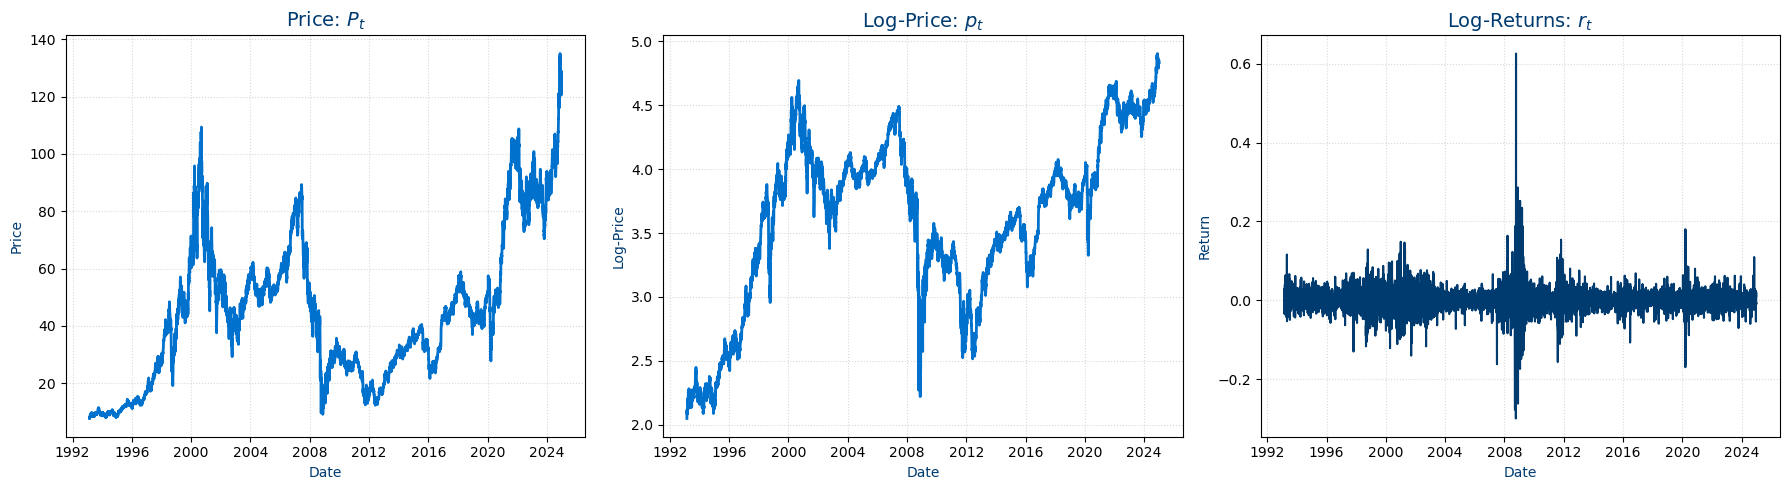

NameError: name 'acf' is not defined

In [10]:
# ======================================================
# Stylized Fact 1 – Prices Are Non-Stationary
# ======================================================

# ======================================================
# Section (a) – Price, Log-Price, and Log-Returns
# ======================================================
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Price
axs[0].plot(Pt_d.index, Pt_d, color=MS_colors['blue'], linewidth=2)
axs[0].set_title('Price: $P_t$', fontsize=14, color=MS_colors['navy'])
axs[0].set_xlabel('Date', color=MS_colors['navy'])
axs[0].set_ylabel('Price', color=MS_colors['navy'])
axs[0].grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)

# Log-Price
axs[1].plot(pt_d.index, pt_d, color=MS_colors['light_blue'], linewidth=2)
axs[1].set_title('Log-Price: $p_t$', fontsize=14, color=MS_colors['navy'])
axs[1].set_xlabel('Date', color=MS_colors['navy'])
axs[1].set_ylabel('Log-Price', color=MS_colors['navy'])
axs[1].grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)

# Log-Returns
axs[2].plot(rt_d.index, rt_d, color=MS_colors['navy'], linewidth=1.5)
axs[2].set_title('Log-Returns: $r_t$', fontsize=14, color=MS_colors['navy'])
axs[2].set_xlabel('Date', color=MS_colors['navy'])
axs[2].set_ylabel('Return', color=MS_colors['navy'])
axs[2].grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)

plt.tight_layout()
plt.savefig('log-returns.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ======================================================
# Section (b) – Autocorrelation of Daily Log Prices
# ======================================================
lags = 40
acf_values = acf(pt_d.dropna(), nlags=lags)
Bartlett_Int = 1.96 / np.sqrt(len(pt_d))
colors = plt.cm.Blues(np.linspace(0.8, 0.2, lags))

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
lag_limits = [lags, 10]

for ax, max_lag in zip(axs, lag_limits):
    for i in range(1, max_lag+1):
        ax.vlines(x=i, ymin=0, ymax=acf_values[i], color=colors[i-1], linewidth=4)
        ax.plot(i, acf_values[i], 'o', color='black')
    ax.hlines([Bartlett_Int, -Bartlett_Int], xmin=1, xmax=max_lag, colors=MS_colors['blue'], linestyles='--', linewidth=2.5)
    ax.hlines(0, xmin=1, xmax=max_lag, colors=MS_colors['grey'], linestyles='-', linewidth=1.5)
    ax.set_xlabel('Lag', color=MS_colors['navy'])
    ax.set_ylabel('Autocorrelation', color=MS_colors['navy'])
    ax.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)

axs[0].set_title('ACF of Daily Log Prices', fontsize=16, color=MS_colors['navy'])
axs[1].set_title('Zoomed ACF (First 10 Lags)', fontsize=16, color=MS_colors['navy'])

plt.tight_layout()
plt.savefig('ACF.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ======================================================
# Section (c) – Scatter Plot: Daily Log Prices vs Lagged Prices
# ======================================================
pt_lag = pt_d[:-1]
pt_curr = pt_d[1:]

xy = np.vstack([pt_lag, pt_curr])
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pt_lag, pt_curr, c=z, cmap='Blues_r', s=50, edgecolor='k', alpha=0.7)

lims = [min(pt_lag.min(), pt_curr.min()), max(pt_lag.max(), pt_curr.max())]
plt.plot(lims, lims, color=MS_colors['navy'], linestyle='--', linewidth=2)

cbar = plt.colorbar(scatter)
cbar.set_label('Point density', color=MS_colors['navy'])
cbar.ax.yaxis.set_tick_params(color=MS_colors['navy'])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=MS_colors['navy'])

plt.title('Scatter Plot of Daily Log Prices vs Lagged Prices', fontsize=14, color=MS_colors['navy'])
plt.xlabel(r'$p_{t-1}$', fontsize=12, color=MS_colors['navy'])
plt.ylabel(r'$p_t$', fontsize=12, color=MS_colors['navy'])
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)
plt.savefig('log_prices_vs_lagged_prices.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ======================================================
# Section (d) – Verification via ADF Test & Moving Average
# ======================================================
plt.figure(figsize=(14, 5))
plt.plot(pt_d, color=MS_colors['blue'], linewidth=2)
window = 50
pt_ma = pt_d.rolling(window=window).mean()
plt.plot(pt_ma, color=MS_colors['light_blue'], linewidth=2, linestyle='--', label=f'{window}-day MA')
plt.title('Daily Log Prices of Morgan Stanley', fontsize=16, color=MS_colors['navy'])
plt.xlabel('Date', color=MS_colors['navy'])
plt.ylabel('Log Price', color=MS_colors['navy'])
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)
plt.legend()
plt.savefig('movingaverage.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

adf_result = adfuller(pt_d.dropna())
print("Augmented Dickey-Fuller Test on Morgan Stanley Daily Log Prices")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")
if adf_result[1] > 0.05:
    print("\nFail to reject H0 → the series is non-stationary, consistent with Stylized Fact 1.")
else:
    print("\nReject H0 → the series is stationary.")

# ======================================================
# Section (e) – Crisis Annotations
# ======================================================
plt.figure(figsize=(14, 5))
plt.plot(pt_d, color=MS_colors['blue'], linewidth=2)
plt.title('Daily Log Prices with Crisis Annotations', fontsize=16, color=MS_colors['navy'])
plt.xlabel('Date', color=MS_colors['navy'])
plt.ylabel('Log Price', color=MS_colors['navy'])
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)

plt.annotate('Dot-com Bubble', 
             xy=(pd.to_datetime('2000-03-10'), pt_d.loc[pd.to_datetime('2000-03-10')]), 
             xytext=(pd.to_datetime('2001-01-01'), pt_d.max()*0.8),
             arrowprops=dict(facecolor='red', shrink=0.05), color='red')
plt.annotate('GFC 2008', 
             xy=(pd.to_datetime('2008-09-15'), pt_d.loc[pd.to_datetime('2008-09-15')]), 
             xytext=(pd.to_datetime('2009-01-01'), pt_d.max()*0.6),
             arrowprops=dict(facecolor='red', shrink=0.05), color='red')

plt.savefig('financial_crisis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ======================================================
# Section (f) – Histogram & KDE of Daily Log-Returns
# ======================================================
plt.figure(figsize=(10, 5))
sns.histplot(rt_d, bins=50, kde=True, color=MS_colors['light_blue'], stat='density')
plt.title('Histogram & KDE of Daily Log-Returns', fontsize=14, color=MS_colors['navy'])
plt.xlabel('Log-Return', color=MS_colors['navy'])
plt.ylabel('Density', color=MS_colors['navy'])
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)
plt.show()

# ======================================================
# Section (g) – KPSS Test for Confirmation
# ======================================================
kpss_stat, p_value, lags, crit = kpss(pt_d.dropna(), regression='c')
print(f"KPSS Statistic: {kpss_stat:.4f}, p-value: {p_value:.4f}")

# ======================================================
# Section (h) – Rolling Mean & Rolling Variance
# ======================================================
rolling_window = 50
fig, ax = plt.subplots(figsize=(14, 6))
line_price, = ax.plot(pt_d, color=MS_colors['blue'], linewidth=2, label='Log-price')
line_ma, = ax.plot(pt_d.rolling(window=rolling_window).mean(), 
                   color=MS_colors['light_blue'], linestyle='--', linewidth=2, 
                   label=f'{rolling_window}-day MA')
ax.set_title('Daily Log Prices with Rolling Mean & Rolling Variance', fontsize=16, color=MS_colors['navy'])
ax.set_xlabel('Date', color=MS_colors['navy'])
ax.set_ylabel('Log Price', color=MS_colors['navy'])
ax.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)

ax2 = ax.twinx()
line_var, = ax2.plot(pt_d.rolling(window=rolling_window).var(), color='red', linestyle='-', linewidth=2, label='Rolling variance')
ax2.set_ylabel('Variance', color='red')

lines = [line_price, line_ma, line_var]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.savefig('rolling_mean.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/gy/nmjd8qn10q995m_v8z9mpq980000gn/T/ipykernel_17960/1031263536.py:73: RuntimeWarning: divide by zero encountered in divide
  std_error = (1 / (2 * sd_plot)) * np.sqrt((mu4 - sd_plot**4) / window_length)
/var/folders/gy/nmjd8qn10q995m_v8z9mpq980000gn/T/ipykernel_17960/1031263536.py:73: RuntimeWarning: invalid value encountered in multiply
  std_error = (1 / (2 * sd_plot)) * np.sqrt((mu4 - sd_plot**4) / window_length)


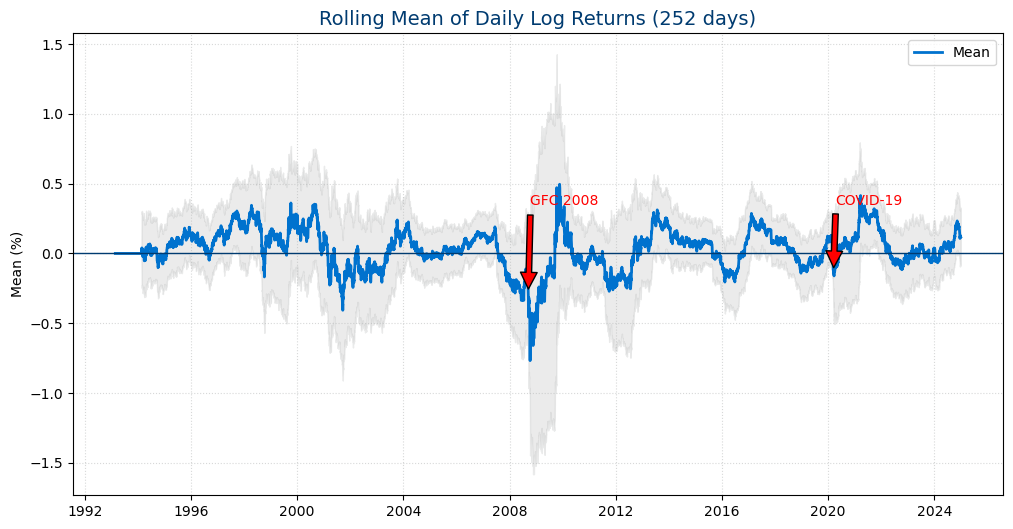

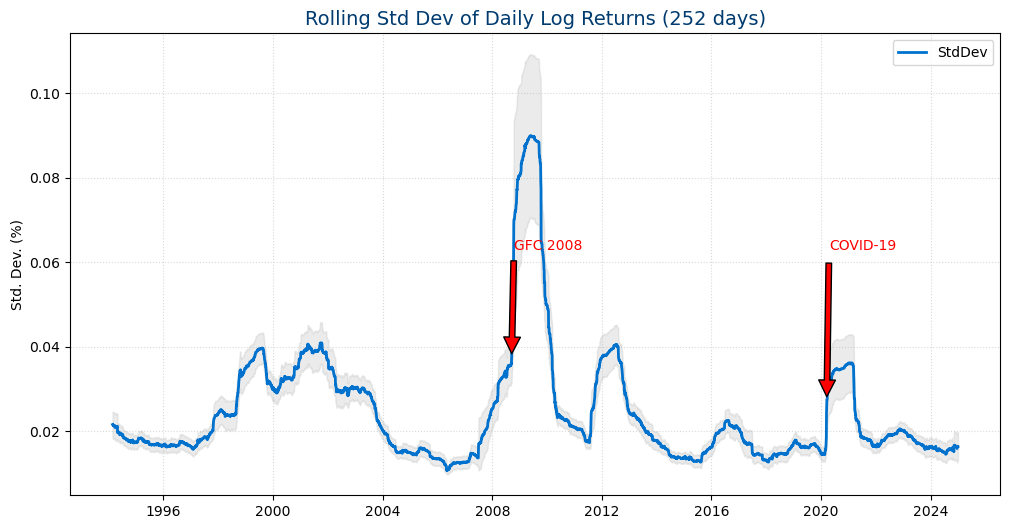

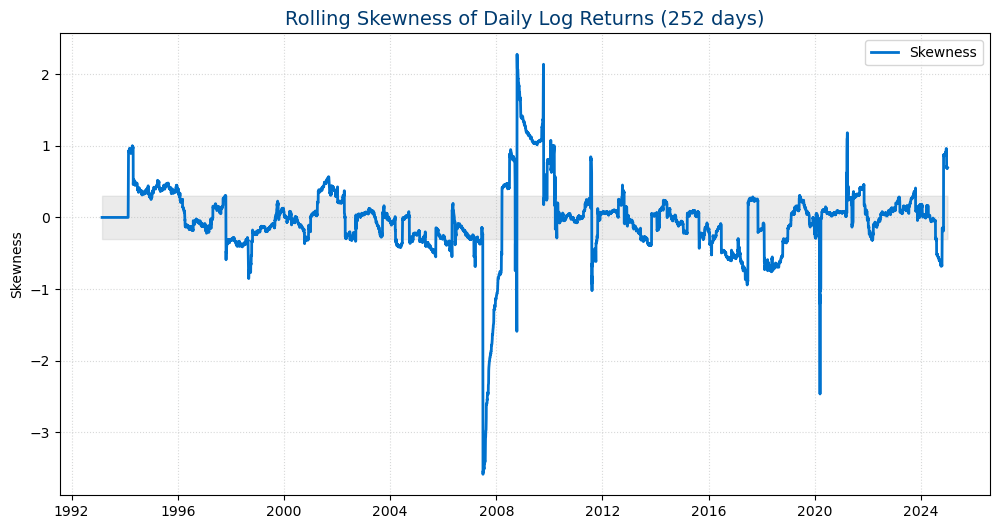

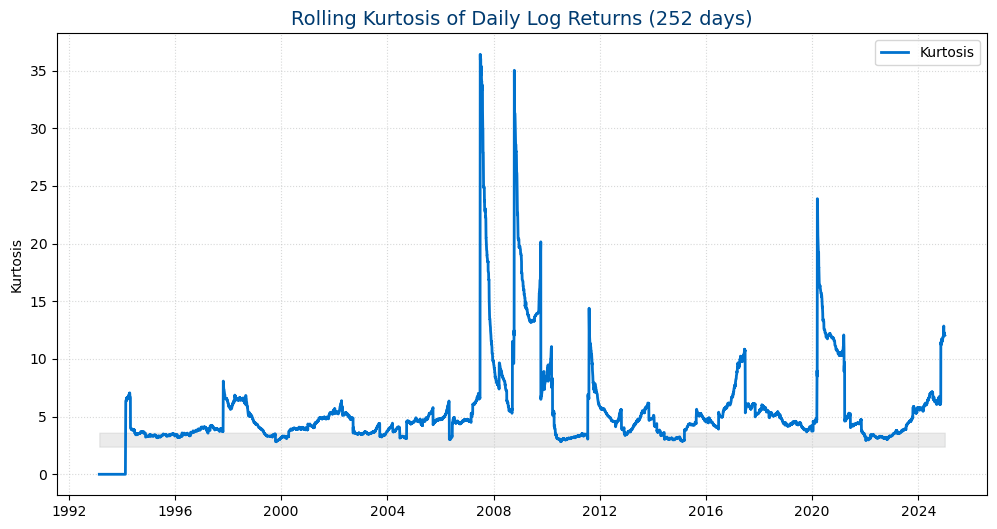

NameError: name 'adfuller' is not defined

In [11]:
# ==============================================
# Stylized Fact 2: Stationarity of Log-Returns
# ==============================================

# ---------------------------
# Parameters
# ---------------------------
window_length = 252  # rolling window (252 trading days)
T = rt_d.shape[0]

# ---------------------------
# Compute rolling moments manually
# ---------------------------
roll_mom_manual = np.zeros((T,5))  # columns: mean, std, skew, kurtosis, 4th central moment

for i in range(window_length, T):
    y = rt_d.iloc[i - window_length + 1:i + 1]
    roll_mom_manual[i,0] = np.mean(y)
    roll_mom_manual[i,1] = np.std(y, ddof=1)
    roll_mom_manual[i,2] = skew(y)
    roll_mom_manual[i,3] = kurtosis(y, fisher=False)  # Pearson
    roll_mom_manual[i,4] = np.mean((y - np.mean(y))**4)

data_index = rt_d.index

# ---------------------------
# Function to plot rolling series
# ---------------------------
def plot_rolling(data, y_col, title, ylabel, annotate_crises=False):
    plt.figure(figsize=(12,6))
    scale = 100 if 'Mean' in y_col else 1
    plt.plot(data.index, data[y_col]*scale, color=MS_colors['blue'], linewidth=2, label=y_col)
    plt.fill_between(data.index, data['LowerBound']*scale, data['UpperBound']*scale,
                     color=MS_colors['grey'], alpha=0.25)
    
    if 'Mean' in y_col:
        plt.axhline(0, color=MS_colors['navy'], linewidth=1)
    
    if annotate_crises:
        crises = {'GFC 2008':'2008-09-15', 'COVID-19':'2020-03-16'}
        for name, date in crises.items():
            date = pd.to_datetime(date)
            if date in data.index:
                plt.annotate(name, 
                             xy=(date, data[y_col].loc[date]*scale),
                             xytext=(date + pd.Timedelta(days=30), data[y_col].max()*scale*0.7),
                             arrowprops=dict(facecolor='red', shrink=0.05),
                             color='red')
    
    plt.title(title, fontsize=14, color=MS_colors['navy'])
    plt.ylabel(ylabel)
    plt.xlabel("")
    plt.legend()
    plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)
    plt.show()

# ---------------------------
# Prepare data for Mean and StdDev
# ---------------------------
# Rolling Mean
mean_plot = roll_mom_manual[:,0]
mean_plot_ub = mean_plot + 1.96 * roll_mom_manual[:,1] / np.sqrt(window_length)
mean_plot_lb = mean_plot - 1.96 * roll_mom_manual[:,1] / np.sqrt(window_length)
data2plot_mean = pd.DataFrame({
    'Mean': mean_plot,
    'LowerBound': mean_plot_lb,
    'UpperBound': mean_plot_ub
}, index=data_index).dropna()

# Rolling StdDev
sd_plot = roll_mom_manual[:,1]
mu4 = roll_mom_manual[:,4]
std_error = (1 / (2 * sd_plot)) * np.sqrt((mu4 - sd_plot**4) / window_length)
sd_plot_ub = sd_plot + 1.96 * std_error
sd_plot_lb = sd_plot - 1.96 * std_error
data2plot_sd = pd.DataFrame({
    'StdDev': sd_plot,
    'LowerBound': sd_plot_lb,
    'UpperBound': sd_plot_ub
}, index=data_index).dropna()

# Rolling Skewness
skew_plot = roll_mom_manual[:,2]
skew_std_error = np.sqrt(6 / window_length)
skew_plot_ub = np.full(skew_plot.shape[0], 1.96 * skew_std_error)
skew_plot_lb = np.full(skew_plot.shape[0], -1.96 * skew_std_error)
data2plot_sk = pd.DataFrame({
    'Skewness': skew_plot,
    'LowerBound': skew_plot_lb,
    'UpperBound': skew_plot_ub
}, index=data_index).dropna()

# Rolling Kurtosis
kurt_plot = roll_mom_manual[:,3]
kurt_std_error = np.sqrt(24 / window_length)
kurt_plot_ub = np.full(kurt_plot.shape[0], 3 + 1.96 * kurt_std_error)
kurt_plot_lb = np.full(kurt_plot.shape[0], 3 - 1.96 * kurt_std_error)
data2plot_kurt = pd.DataFrame({
    'Kurtosis': kurt_plot,
    'LowerBound': kurt_plot_lb,
    'UpperBound': kurt_plot_ub
}, index=data_index).dropna()

# ---------------------------
# Plot all rolling moments
# ---------------------------
plot_rolling(data2plot_mean, 'Mean', 'Rolling Mean of Daily Log Returns (252 days)', 'Mean (%)', annotate_crises=True)
plot_rolling(data2plot_sd, 'StdDev', 'Rolling Std Dev of Daily Log Returns (252 days)', 'Std. Dev. (%)', annotate_crises=True)
plot_rolling(data2plot_sk, 'Skewness', 'Rolling Skewness of Daily Log Returns (252 days)', 'Skewness')
plot_rolling(data2plot_kurt, 'Kurtosis', 'Rolling Kurtosis of Daily Log Returns (252 days)', 'Kurtosis')

# ---------------------------
# ADF Test for Stationarity
# ---------------------------
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")
    if result[1] > 0.05:
        print("Series is likely non-stationary → consider differencing")
    else:
        print("Series is likely stationary")

adf_test(rt_d, "Daily Log Returns")
adf_test(rt_m, "Monthly Log Returns")

# ---------------------------
# QQ Plots and Time Series
# ---------------------------
fig, axes = plt.subplots(2, 2, figsize=(18,10), gridspec_kw={'width_ratios':[2,1]})
axes[0,0].plot(rt_d.index, rt_d, color=MS_colors['navy'], linewidth=1.5)
axes[0,0].axhline(0, color=MS_colors['grey'], linestyle='--')
axes[0,0].set_title('Daily Log Returns', fontsize=14, color=MS_colors['navy'])
axes[0,1].set_title('QQ Plot - Daily Returns', fontsize=14, color=MS_colors['navy'])
probplot(rt_d, dist='norm', plot=axes[0,1])
axes[1,0].plot(rt_m.index, rt_m, color=MS_colors['blue'], linewidth=1.5)
axes[1,0].axhline(0, color=MS_colors['grey'], linestyle='--')
axes[1,0].set_title('Monthly Log Returns', fontsize=14, color=MS_colors['navy'])
axes[1,1].set_title('QQ Plot - Monthly Returns', fontsize=14, color=MS_colors['navy'])
probplot(rt_m, dist='norm', plot=axes[1,1])
plt.tight_layout()
plt.show()

# ---------------------------
# ACF & PACF
# ---------------------------
lags = 40
fig, axes = plt.subplots(1,2, figsize=(18,5))
plot_acf(rt_d, lags=lags, ax=axes[0], alpha=0.05)
axes[0].set_title("ACF of Daily Log Returns", fontsize=16, color=MS_colors['navy'])
plot_pacf(rt_d, lags=lags, ax=axes[1], alpha=0.05, zero=False)
axes[1].set_title("PACF of Daily Log Returns", fontsize=16, color=MS_colors['navy'])
plt.tight_layout()
plt.show()

# ---------------------------
# Density scatter plot of lagged returns
# ---------------------------
rt_lag = rt_d[:-1]
rt_curr = rt_d[1:]
xy = np.vstack([rt_lag, rt_curr])
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(8,6))
scatter = plt.scatter(rt_lag, rt_curr, c=z, s=50, edgecolor='k', alpha=0.7, cmap='Blues_r')
lims = [min(rt_lag.min(), rt_curr.min()), max(rt_lag.max(), rt_curr.max())]
plt.plot(lims, lims, color=MS_colors['navy'], linestyle='--', lw=2)
plt.title('Daily Log Returns vs Lagged Returns Density Plot', fontsize=14, color=MS_colors['navy'])
plt.xlabel(r'Previous Return $r_{t-1}$', fontsize=12, color=MS_colors['navy'])
plt.ylabel(r'Current Return $r_t$', fontsize=12, color=MS_colors['navy'])
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)
plt.colorbar(scatter, label='Density')
plt.show()


In [ ]:
# ==============================================
# Stylized Fact 3: Skewness & Non-Normality of Morgan Stanley Log Returns
# ==============================================

# ---------------------------
# 0) Resample log-returns for different frequencies
# ---------------------------
rt_w = rt_d.resample('W').sum()    # Weekly
rt_m = rt_d.resample('ME').sum()   # Monthly
rt_y = rt_d.resample('YE').sum()   # Yearly

# ---------------------------
# 1) Skewness by frequency
# ---------------------------
skews = {
    'Daily': skew(rt_d.dropna()),
    'Weekly': skew(rt_w.dropna()),
    'Monthly': skew(rt_m.dropna()),
    'Yearly': skew(rt_y.dropna())
}

print("Skewness by frequency:")
for freq, val in skews.items():
    print(f"{freq}: {val:.3f}")

# ---------------------------
# 2) Jarque-Bera test by frequency
# ---------------------------
jb_results = {}
for freq_name, series in zip(['Daily','Weekly','Monthly','Yearly'], [rt_d, rt_w, rt_m, rt_y]):
    jb_stat, jb_p = jarque_bera(series.dropna())
    jb_results[freq_name] = (jb_stat, jb_p)

print("\nJarque-Bera test results:")
for freq, (stat, pval) in jb_results.items():
    print(f"{freq}: JB stat={stat:.2f}, p-value={pval:.4f}")

# ---------------------------
# 3) Histogram & KDE for daily returns
# ---------------------------
plt.figure(figsize=(10,5))
sns.histplot(rt_d, bins=50, kde=True, color=MS_colors['light_blue'], stat='density')
plt.axvline(rt_d.mean(), color='red', linestyle='--', label='Mean')
plt.title('Histogram & KDE of Daily Log Returns (Morgan Stanley)', fontsize=14, color=MS_colors['navy'])
plt.xlabel('Log-Return', color=MS_colors['navy'])
plt.ylabel('Density', color=MS_colors['navy'])
plt.legend()
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)
plt.savefig('Histogram_KDE_Daily_Log_Returns.png', dpi=300)
plt.show()

# ---------------------------
# 4) Rolling skewness
# ---------------------------
window = 252
rolling_skew = rt_d.rolling(window=window).apply(skew)

plt.figure(figsize=(14,5))
plt.plot(rolling_skew, color=MS_colors['navy'], linewidth=2, label=f'{window}-day Rolling Skewness')

# 5) Highlight crises
crises = {
    'Dot-com Bubble': ('2000-03-01', '2002-03-01'),
    'GFC 2008': ('2008-09-01', '2009-03-01'),
    'COVID-19': ('2020-02-01', '2020-06-01')
}

for label, (start, end) in crises.items():
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2)
    plt.text(pd.to_datetime(start), rolling_skew.max()*0.8, label, color='red')

plt.axhline(0, color=MS_colors['grey'], linestyle='--')
plt.title(f'{window}-Day Rolling Skewness of Morgan Stanley Daily Log-Returns', fontsize=16, color=MS_colors['navy'])
plt.xlabel('Date', color=MS_colors['navy'])
plt.ylabel('Skewness', color=MS_colors['navy'])
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.5)
plt.legend()
plt.savefig('Rolling_Skewness_Daily_Log_Returns.png', dpi=300)
plt.show()

# ---------------------------
# 6) Skewness during crises
# ---------------------------
print("\nSkewness during crises:")
for label, (start, end) in crises.items():
    mask = (rt_d.index >= pd.to_datetime(start)) & (rt_d.index <= pd.to_datetime(end))
    skew_crisis = skew(rt_d[mask])
    print(f"{label}: Skewness = {skew_crisis:.2f}")

# ---------------------------
# 7) Annual boxplot to visualize temporal asymmetry
# ---------------------------
rt_d_yearly = rt_d.copy().to_frame(name='LogReturn')
rt_d_yearly['Year'] = rt_d_yearly.index.year

plt.figure(figsize=(16,6))
sns.boxplot(x='Year', y='LogReturn', data=rt_d_yearly, color=MS_colors['light_blue'])
plt.xticks(rotation=90)
plt.title('Annual Distribution of Morgan Stanley Daily Log-Returns', fontsize=16, color=MS_colors['navy'])
plt.xlabel('Year', color=MS_colors['navy'])
plt.ylabel('Daily Log-Return', color=MS_colors['navy'])
plt.grid(True, linestyle=':', color=MS_colors['grey'], alpha=0.3)
plt.savefig('Annual_Boxplot_Daily_Log_Returns.png', dpi=300)
plt.show()

# ---------------------------
# 8) Jarque-Bera test on daily returns
# ---------------------------
jb_stat, jb_pvalue = jarque_bera(rt_d.dropna())
print(f"\nJarque-Bera test on daily returns: JB Stat = {jb_stat:.2f}, p-value = {jb_pvalue:.4f}")

In [ ]:
# ============================================================
# Stylized Fact 4: Heavy Tails in Morgan Stanley Returns
# ============================================================
# ============================================================
# 0) Color Palette
# ============================================================
MS_colors = { 
    'blue': '#0072CE', 
    'light_blue': '#0072CE', 
    'navy': '#003B70', 
    'grey': '#B1B3B3', 
    'white': '#FFFFFF'
}

# ============================================================
# 1) Store return series by frequency
# ============================================================
X = {'daily': rt_d, 'monthly': rt_m}

# ============================================================
# 2) Histogram & Normal Distribution Fit
# ============================================================
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

for i, (freq, returns) in enumerate(X.items()):
    mu, sigma = np.mean(returns), np.std(returns, ddof=1)
    x = np.linspace(returns.min(), returns.max(), 1000)
    
    # Histogram
    axs[i].hist(returns, bins=50, density=True, color=MS_colors['light_blue'], edgecolor=MS_colors['white'])
    
    # Normal density overlay
    axs[i].plot(x, stats.norm.pdf(x, mu, sigma), color=MS_colors['navy'], linewidth=2, label='Normal Distribution')
    
    # Median line
    axs[i].axvline(np.median(returns), color=MS_colors['grey'], linestyle='--', linewidth=2, label='Median')
    
    # Titles & labels
    axs[i].set_title(f"{freq.capitalize()} Log Returns – Histogram & Normal Fit", fontsize=14, color=MS_colors['navy'])
    axs[i].set_xlabel(f"{freq.capitalize()} Log Returns", fontsize=12, color=MS_colors['navy'])
    axs[i].set_ylabel("Density", fontsize=12, color=MS_colors['navy'])
    axs[i].legend()
    axs[i].grid(False)

plt.tight_layout()
plt.savefig('Hist_Normal_Fit_Daily_Monthly.png', dpi=300)
plt.show()

# ============================================================
# 3) QQ-Plot vs Normal Distribution
# ============================================================
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

for i, (freq, returns) in enumerate(X.items()):
    standardized = (returns - np.mean(returns)) / np.std(returns, ddof=1)
    stats.probplot(standardized, dist="norm", plot=axs[i])
    axs[i].get_lines()[0].set_color(MS_colors['light_blue'])
    axs[i].get_lines()[1].set_color(MS_colors['navy'])
    axs[i].set_title(f"{freq.capitalize()} Log Returns – QQ Plot vs Normal", fontsize=14, color=MS_colors['navy'])
    axs[i].grid(False)

plt.tight_layout()
plt.savefig('QQ_Normal_Daily_Monthly.png', dpi=300)
plt.show()

# ============================================================
# 4) QQ-Plot vs Student-t Distributions (Heavy Tails Check)
# ============================================================
dfs = [5, 4, 3]
fig, axs = plt.subplots(1, len(dfs), figsize=(18, 5))

for j, df in enumerate(dfs):
    stats.probplot(X['daily'] / np.std(X['daily'], ddof=1), dist=stats.t(df=df), plot=axs[j])
    axs[j].get_lines()[0].set_color(MS_colors['light_blue'])
    axs[j].get_lines()[1].set_color(MS_colors['navy'])
    axs[j].set_title(f"QQ Plot – Student-t (ν={df})", fontsize=13, color=MS_colors['navy'])
    axs[j].grid(False)

plt.suptitle("Daily Log Returns – Comparison with Student-t Distributions", fontsize=16, color=MS_colors['navy'])
plt.tight_layout()
plt.savefig('QQ_StudentT_Daily.png', dpi=300)
plt.show()


In [ ]:
# ===================================================
# Stylized Fact 5: Heavy Tails in Morgan Stanley Returns
# ===================================================

# MS Colors
MS_colors = {
    'blue': '#0072CE',
    'light_blue': '#66B2FF',
    'navy': '#003B70',
    'grey': '#7A7A7A',
    'white': '#FFFFFF'
}

returns_dict = {'daily': rt_d, 'monthly': rt_m, 'annual': rt_y}

# ---------------------------------------------------
# 1. Kernel Density Estimate (KDE) + Normal Fit
# ---------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

for i, (freq, returns) in enumerate({'daily': returns_dict['daily'], 'monthly': returns_dict['monthly']}.items()):
    mu, sigma = np.mean(returns), np.std(returns, ddof=1)
    x_vals = np.linspace(returns.min(), returns.max(), 1000)
    
    sns.kdeplot(returns, bw_adjust=0.5, color=MS_colors['blue'], ax=axs[i], label='Kernel Density')
    axs[i].plot(x_vals, stats.norm.pdf(x_vals, mu, sigma), color=MS_colors['navy'], linewidth=2, label='Normal Distribution')
    axs[i].axvline(np.median(returns), color=MS_colors['grey'], linestyle='--', linewidth=2, label='Median')
    
    axs[i].set_title(f'{freq.capitalize()} Log Returns – KDE & Normal Fit', fontsize=14, color=MS_colors['navy'])
    axs[i].set_xlabel('Log Return', fontsize=12, color=MS_colors['navy'])
    axs[i].set_ylabel('Density', fontsize=12, color=MS_colors['navy'])
    axs[i].legend()
    axs[i].grid(False)

plt.tight_layout()
plt.savefig('KDE_vs_Normal.png', dpi=300)
plt.show()

# ---------------------------------------------------
# 2. Empirical CDF vs Normal CDF
# ---------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

for i, (freq, returns) in enumerate({'daily': returns_dict['daily'], 'monthly': returns_dict['monthly']}.items()):
    sorted_returns = np.sort(returns)
    n = len(sorted_returns)
    empirical_cdf = np.arange(1, n+1)/n
    
    mu, sigma = np.mean(returns), np.std(returns, ddof=1)
    normal_cdf = stats.norm.cdf(sorted_returns, loc=mu, scale=sigma)
    
    axs[i].step(sorted_returns, empirical_cdf, color=MS_colors['blue'], label='Empirical CDF', where='post')
    axs[i].plot(sorted_returns, normal_cdf, color=MS_colors['navy'], linestyle='--', linewidth=2, label='Normal CDF')
    
    axs[i].set_title(f'{freq.capitalize()} Log Returns – Empirical vs Normal CDF', fontsize=14, color=MS_colors['navy'])
    axs[i].set_xlabel('Log Return', fontsize=12, color=MS_colors['navy'])
    axs[i].set_ylabel('CDF', fontsize=12, color=MS_colors['navy'])
    axs[i].legend()
    axs[i].grid(False)

plt.tight_layout()
plt.savefig('Empirical_vs_Normal_CDF.png', dpi=300)
plt.show()

# ---------------------------------------------------
# 3. Lilliefors Test Plot (Monthly & Annual)
# ---------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
fig.subplots_adjust(wspace=0.4)

K_10, K_5, K_1 = 0.089, 0.094, 0.116  # critical values

for ax, (label, returns) in zip(axs, {'Monthly': returns_dict['monthly'], 'Annual': returns_dict['annual']}.items()):
    sorted_returns = np.sort(returns.values.flatten())
    n = len(sorted_returns)
    empirical_cdf = np.arange(1, n+1)/n
    
    mu_hat, sigma_hat = np.mean(returns), np.std(returns, ddof=1)
    normal_cdf = stats.norm.cdf(sorted_returns, loc=mu_hat, scale=sigma_hat)
    
    abs_diff = np.abs(empirical_cdf - normal_cdf)
    KS_L_stat = np.max(abs_diff)
    
    ax.plot(sorted_returns, abs_diff, color=MS_colors['blue'], linewidth=1)
    ax.axhline(K_10, color='orange', linestyle='--', linewidth=2)
    ax.axhline(K_5, color='red', linestyle='--', linewidth=2)
    ax.axhline(K_1, color='darkred', linestyle='--', linewidth=2)
    
    ax.text(sorted_returns.min(), K_10-0.006, f'10% crit. KS_L={K_10:.3f}', fontsize=8, color='orange')
    ax.text(sorted_returns.min(), K_5+0.002, f'5% crit. KS_L={K_5:.3f}', fontsize=8, color='red')
    ax.text(sorted_returns.min(), K_1+0.002, f'1% crit. KS_L={K_1:.3f}', fontsize=8, color='darkred')
    ax.text(sorted_returns.min(), 0.015, r'$|G(r_t)-\Phi(r_t;\hat{\mu},\hat{\sigma}^2)|$', fontsize=9, color=MS_colors['navy'])
    
    ax.set_xlabel(f'Sorted {label} Log Returns', fontsize=12, color=MS_colors['navy'])
    ax.set_ylabel(r'$|G(r_t)-\Phi(r_t;\mu,\sigma^2)|$', fontsize=12, color=MS_colors['navy'])
    ax.set_title(f'Lilliefors Test for Normality ({label} Returns)', fontsize=14, color=MS_colors['navy'])
    ax.grid(False)
    
    print(f'{label} Returns:')
    print(f'Lilliefors statistic (KS_L_stat): {KS_L_stat:.4f}')
    print(f'10% Critical Value: {K_10:.4f}')
    print(f'5% Critical Value: {K_5:.4f}')
    print(f'1% Critical Value: {K_1:.4f}')
    print('-'*50)

plt.tight_layout()
plt.savefig("Lilliefors_Test_MS.png", dpi=300)
plt.show()


In [ ]:
# ============================================================
# Stylized Fact 6: Returns Are Not Autocorrelated (Morgan Stanley)
# ============================================================
# ============================================================
# 0) Morgan Stanley Color Palette
# ============================================================
MS_colors = {
    'blue': '#0072CE',
    'navy': '#003B70',
    'light_blue': '#66B2FF',
    'grey': '#444444',
    'red': '#D72638'
}

# ============================================================
# 1️⃣ Download & Prepare Data
# ============================================================
data = yf.download("MS", start="1988-01-01", end="2023-12-31", auto_adjust=True)
Pt_d = data['Close']

pt_d = np.log(Pt_d)
pt_w = pt_d.resample('W').last()
pt_m = pt_d.resample('M').last()
pt_y = pt_d.resample('Y').last()

rt_d = pt_d.diff().dropna()
rt_w = pt_w.diff().dropna()
rt_m = pt_m.diff().dropna()
rt_y = pt_y.diff().dropna()

returns_dict = {'Daily': rt_d, 'Weekly': rt_w, 'Monthly': rt_m, 'Annual': rt_y}

# ============================================================
# 2️⃣ ACF Plots (Lags 1–40)
# ============================================================
lags = 40
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

for i, (freq, r) in enumerate(returns_dict.items()):
    row, col = divmod(i, 2)
    acf_values = acf(r, nlags=lags)
    confint = 1.96 / np.sqrt(len(r))
    
    axs[row][col].stem(np.arange(1, len(acf_values)), acf_values[1:], linefmt=MS_colors['blue'], markerfmt='o', basefmt=' ')
    axs[row][col].axhline(y=confint, color=MS_colors['red'], linestyle='--', linewidth=1)
    axs[row][col].axhline(y=-confint, color=MS_colors['red'], linestyle='--', linewidth=1)
    axs[row][col].axhline(y=0, color=MS_colors['grey'], linestyle='--', linewidth=1)
    
    axs[row][col].set_title(f"{freq} Log Returns – ACF (Lags 1–{lags})", fontsize=13, color=MS_colors['navy'])
    axs[row][col].set_xlabel("Lag", color=MS_colors['navy'])
    axs[row][col].set_ylabel("Autocorrelation", color=MS_colors['navy'])
    axs[row][col].grid(False)

plt.tight_layout()
plt.savefig("ACF_Daily_Weekly_Monthly_Annual.png", dpi=300)
plt.show()

# ============================================================
# 3️⃣ Zoom on short-term dependence (first 10 lags)
# ============================================================
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

for i, (freq, r) in enumerate(returns_dict.items()):
    row, col = divmod(i, 2)
    acf_values = acf(r, nlags=10)
    confint = 1.96 / np.sqrt(len(r))
    
    axs[row][col].stem(np.arange(1, 11), acf_values[1:], linefmt=MS_colors['light_blue'], markerfmt='o', basefmt=' ')
    axs[row][col].axhline(y=confint, color=MS_colors['red'], linestyle='--')
    axs[row][col].axhline(y=-confint, color=MS_colors['red'], linestyle='--')
    axs[row][col].axhline(y=0, color=MS_colors['grey'], linestyle='--')
    axs[row][col].set_title(f"{freq} Returns – ACF (Zoom on 10 Lags)", fontsize=13, color=MS_colors['navy'])
    axs[row][col].set_xlabel("Lag", color=MS_colors['navy'])

plt.tight_layout()
plt.savefig("ACF_10Lags_Daily_Weekly_Monthly_Annual.png", dpi=300)
plt.show()

# ============================================================
# 4️⃣ Statistical Tests: Box-Pierce & Ljung-Box
# ============================================================
def compute_tests(r, max_lag=20):
    lags_arr = np.arange(1, max_lag + 1)
    ljung = sm.stats.acorr_ljungbox(r, lags=lags_arr, return_df=True)
    bp = sm.stats.acorr_ljungbox(r, lags=lags_arr, boxpierce=True, return_df=True)
    return pd.DataFrame({
        'Lag': lags_arr,
        'Ljung-Box p-value': ljung['lb_pvalue'].values,
        'Box-Pierce p-value': bp['bp_pvalue'].values
    })

results = {freq: compute_tests(r) for freq, r in returns_dict.items()}

for freq, df in results.items():
    sig = (df['Ljung-Box p-value'] < 0.05).any()
    print(f"\n{freq} Returns:")
    print(df.head(10))
    if sig:
        print("Some autocorrelations are significant → Possible short-term dependence.")
    else:
        print("No significant autocorrelation detected – Stylized Fact 6 holds.")

# ============================================================
# 5️⃣ ACF of Absolute Returns (Preview of Volatility Clustering)
# ============================================================
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

for i, (freq, r) in enumerate(returns_dict.items()):
    row, col = divmod(i, 2)
    acf_abs = acf(abs(r), nlags=40)
    confint = 1.96 / np.sqrt(len(r))
    
    axs[row][col].stem(np.arange(1, len(acf_abs)), acf_abs[1:], linefmt=MS_colors['blue'], markerfmt='o', basefmt=' ')
    axs[row][col].axhline(y=confint, color=MS_colors['red'], linestyle='--')
    axs[row][col].axhline(y=-confint, color=MS_colors['red'], linestyle='--')
    axs[row][col].set_title(f"ACF of |{freq} Returns| (Absolute Values)", fontsize=13, color=MS_colors['navy'])

plt.tight_layout()
plt.savefig("ACF_Absolute_Returns.png", dpi=300)
plt.show()


In [ ]:
# ============================================================
# Stylized Fact 7: ACF of Squared Log Returns Only
# ============================================================

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Morgan Stanley colors
MS_colors = {
    'blue': '#0072CE',
    'navy': '#003B70',
    'light_blue': '#66B2FF',
    'grey': '#444444'
}

# Number of lags = min(40, len(series)-1)
fig, axs = plt.subplots(1, len(returns_dict), figsize=(6*len(returns_dict), 5))
if len(returns_dict) == 1:
    axs = [axs]

for i, (freq, r) in enumerate(returns_dict.items()):
    max_lags = min(40, len(r)-1)
    acf_values = acf(r**2, nlags=max_lags, fft=False)
    confint = 1.96 / np.sqrt(len(r))
    
    axs[i].stem(range(1, len(acf_values)), acf_values[1:], 
                linefmt=MS_colors['light_blue'], markerfmt='o', basefmt='w-', label='ACF')
    axs[i].axhline(y=0, color=MS_colors['grey'], linestyle='--')
    axs[i].axhline(y=confint, color='red', linestyle='--')
    axs[i].axhline(y=-confint, color='red', linestyle='--')
    
    axs[i].set_title(f"ACF – {freq} Squared Log Returns", fontsize=13, color=MS_colors['navy'])
    axs[i].set_xlabel("Lag", color=MS_colors['navy'])
    axs[i].set_ylabel("Autocorrelation", color=MS_colors['navy'])
    axs[i].set_ylim(-0.05, 0.35)
    axs[i].grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# ======================================================
# Stylized Fact 8 – Leverage Effect 
# ======================================================

# ======================================================
# Color definitions
# ======================================================
MS_blue = '#2576BE'
grey = '#B1B3B3'

# ======================================================
# Section 1 – Cross-correlation (CCF)
# ======================================================
lags = range(-6, 7)
ccf_vals = []
ccf_n = []

for j in lags:
    series1 = rt.shift(-j)  # future returns
    series2 = rt2            # current squared returns
    df = np.column_stack((series1, series2))
    mask = ~np.isnan(df).any(axis=1)
    df_clean = df[mask]
    if len(df_clean) > 0:
        corr = np.corrcoef(df_clean[:,0], df_clean[:,1])[0,1]
        ccf_vals.append(corr)
        ccf_n.append(len(df_clean))
    else:
        ccf_vals.append(np.nan)
        ccf_n.append(0)

ccf = np.array(ccf_vals)
N_eff = min([n for n in ccf_n if n>0])
conf_bound = 1.96 / np.sqrt(N_eff)

# Plot and save CCF
plt.figure(figsize=(9,5))
plt.bar(lags, ccf, color=MS_blue, edgecolor='k')
plt.axhline(conf_bound, color='red', linestyle='--', linewidth=1.5)
plt.axhline(-conf_bound, color='red', linestyle='--', linewidth=1.5)
plt.axhline(0, color=grey, linewidth=1)
plt.title('CCF MS Returns vs Future Squared Returns', color=MS_blue)
plt.xlabel('Lag j', color=MS_blue)
plt.ylabel('Correlation', color=MS_blue)
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.savefig('SF8_CCF_MS_returns_vs_squared_returns.png', dpi=300)
plt.show()

# ======================================================
# Section 2 – Scatter plot MS returns vs ΔVIX
# ======================================================
xy = np.vstack([merged['MS_rt'], merged['dVIX']])
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
plt.scatter(merged['MS_rt'], merged['dVIX'], c=z, cmap='coolwarm', s=25, alpha=0.7)
sns.regplot(x='MS_rt', y='dVIX', data=merged, scatter=False, line_kws={'color':'#003B70', 'linewidth':2.2})
plt.title('MS Daily Returns vs ΔVIX', fontsize=14, color=MS_blue)
plt.xlabel('MS Daily Log-Return')
plt.ylabel('ΔVIX')
plt.axhline(0, color=grey, linestyle='--', linewidth=1)
plt.axvline(0, color=grey, linestyle='--', linewidth=1)
plt.colorbar(label='Point Density')
plt.tight_layout()
plt.savefig('SF8_scatter_MS_returns_vs_dVIX.png', dpi=300)
plt.show()

# ======================================================
# Section 3 – Rolling correlation (lag=1, window=250 trading days)
# ======================================================
lag = 1
rolling_corr = rt.shift(-lag).rolling(250).corr(rt2)

plt.figure(figsize=(11,4))
plt.plot(rolling_corr.index, rolling_corr.values, color=MS_blue, linewidth=1.5)
plt.axhline(0, color=grey)
plt.title('Rolling Correlation r_{t+1} vs r_t^2 (250-day window)', color=MS_blue)
plt.ylabel('Rolling Correlation')
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.savefig('SF8_rolling_corr_r_tplus1_vs_r_t2.png', dpi=300)
plt.show()


In [ ]:
# ======================================================
# QUESTION 2: CAPM & FAMA-FRENCH 3-FACTORS REGRESSION
# ======================================================

# ======================================================
# 1. DATA PREPARATION
# ======================================================

# Load Fama-French monthly factors
ff_m = pd.read_csv("F-F_Research_Data_Factors.csv", skiprows=4, index_col=0)
ff_m = ff_m.apply(pd.to_numeric, errors='coerce')
ff_m = ff_m[ff_m.index.astype(str).str.match(r'^\d{6}$')]
ff_m.index = pd.to_datetime(ff_m.index, format='%Y%m')
ff_m = ff_m / 100
ff_m = ff_m.loc['1993-02':'2024-12']

# Convert Fama-French to end-of-month frequency to match MS returns
ff_m = ff_m.resample('ME').last()

# MS monthly returns data preparation
ms_returns = rt_m  # Monthly returns calculated previously

# Align dates between MS returns and Fama-French factors
common_index = ms_returns.index.intersection(ff_m.index)
ms_returns_aligned = ms_returns.loc[common_index]
ff_m_aligned = ff_m.loc[common_index]

# Ensure ms_returns_aligned is a Series
if isinstance(ms_returns_aligned, pd.DataFrame):
    ms_returns_aligned = ms_returns_aligned.iloc[:, 0]

# Calculate excess returns
rf = ff_m_aligned['RF']
excess_ms = ms_returns_aligned - rf
excess_mkt = ff_m_aligned['Mkt-RF']

# Remove any remaining NaN values
mask = ~(excess_ms.isna() | excess_mkt.isna())
excess_ms_clean = excess_ms[mask]
excess_mkt_clean = excess_mkt[mask]

print(f"Final dataset: {len(excess_ms_clean)} monthly observations")
print(f"Sample period: {excess_ms_clean.index.min().strftime('%Y-%m')} to {excess_ms_clean.index.max().strftime('%Y-%m')}")

# ======================================================
# 2. CAPM REGRESSION
# ======================================================

X_capm = sm.add_constant(excess_mkt_clean)
y = excess_ms_clean

# CAPM with standard errors
capm_model = sm.OLS(y, X_capm).fit()

# CAPM with robust standard errors
try:
    capm_model_robust = sm.OLS(y, X_capm).fit(cov_type='HC3')
    robust_method_capm = 'HC3'
except:
    capm_model_robust = sm.OLS(y, X_capm).fit(cov_type='HC0')
    robust_method_capm = 'HC0'

print("="*70)
print("CAPM MARKET MODEL REGRESSION RESULTS")
print("="*70)
print(capm_model.summary())
print(f"\nCAPM with robust standard errors ({robust_method_capm}):")
print(capm_model_robust.summary())

# ======================================================
# 3. FAMA-FRENCH 3-FACTORS REGRESSION
# ======================================================

X_ff3 = ff_m_aligned[['Mkt-RF', 'SMB', 'HML']].loc[excess_ms_clean.index]
X_ff3 = sm.add_constant(X_ff3)

# Fama-French 3-factors with standard errors
ff3_model = sm.OLS(y, X_ff3).fit()

# Fama-French 3-factors with robust standard errors
try:
    ff3_model_robust = sm.OLS(y, X_ff3).fit(cov_type='HC3')
    robust_method_ff3 = 'HC3'
except:
    ff3_model_robust = sm.OLS(y, X_ff3).fit(cov_type='HC0')
    robust_method_ff3 = 'HC0'

print("\n" + "="*70)
print("FAMA-FRENCH 3-FACTORS MODEL REGRESSION RESULTS")
print("="*70)
print(ff3_model.summary())
print(f"\nFama-French 3-factors with robust standard errors ({robust_method_ff3}):")
print(ff3_model_robust.summary())

# ======================================================
# 4. REGRESSION DIAGNOSTICS
# ======================================================

print("\n" + "="*70)
print("REGRESSION DIAGNOSTICS AND SPECIFICATION TESTS")
print("="*70)

# Heteroskedasticity tests
bp_capm = het_breuschpagan(capm_model.resid, capm_model.model.exog)
bp_ff3 = het_breuschpagan(ff3_model.resid, ff3_model.model.exog)

print("Breusch-Pagan Test for Heteroskedasticity:")
print(f"CAPM: LM statistic = {bp_capm[0]:.4f}, p-value = {bp_capm[1]:.4f}")
print(f"FF3:  LM statistic = {bp_ff3[0]:.4f}, p-value = {bp_ff3[1]:.4f}")

# Autocorrelation tests
print("\nDurbin-Watson Test for Autocorrelation:")
print(f"CAPM: {durbin_watson(capm_model.resid):.4f}")
print(f"FF3:  {durbin_watson(ff3_model.resid):.4f}")

# Model comparison
print("\nModel Comparison:")
print(f"CAPM R-squared: {capm_model.rsquared:.4f}")
print(f"FF3 R-squared:  {ff3_model.rsquared:.4f}")
print(f"R-squared improvement: {ff3_model.rsquared - capm_model.rsquared:.4f}")

# ======================================================
# 5. VISUALIZATION
# ======================================================

# 5.1 CAPM Fitted Regression Line
plt.figure(figsize=(10, 6))
plt.scatter(excess_mkt_clean, y, alpha=0.6, color='blue', s=30, label='MS excess returns')
plt.plot(excess_mkt_clean, capm_model.predict(X_capm), color='red', 
         linewidth=2.5, label='Fitted CAPM line')
plt.xlabel('Market Excess Return (Mkt-RF)')
plt.ylabel('MS Excess Return')
plt.title('CAPM: Morgan Stanley vs Market - Fitted Regression Line')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('capm_regression_line.png', dpi=300, bbox_inches='tight')
plt.show()

# 5.2 Residual Diagnostics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# CAPM residuals vs fitted
axes[0,0].scatter(capm_model.fittedvalues, capm_model.resid, alpha=0.6, color='blue')
axes[0,0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('CAPM: Residuals vs Fitted Values')
axes[0,0].grid(True, alpha=0.3)

# FF3 residuals vs fitted
axes[0,1].scatter(ff3_model.fittedvalues, ff3_model.resid, alpha=0.6, color='green')
axes[0,1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0,1].set_xlabel('Fitted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('FF3: Residuals vs Fitted Values')
axes[0,1].grid(True, alpha=0.3)

# CAPM Q-Q plot
probplot(capm_model.resid, dist="norm", plot=axes[1,0])
axes[1,0].set_title('CAPM: Q-Q Plot for Normality')

# FF3 Q-Q plot
probplot(ff3_model.resid, dist="norm", plot=axes[1,1])
axes[1,1].set_title('FF3: Q-Q Plot for Normality')

plt.tight_layout()
plt.savefig('regression_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

# 5.3 Heteroskedasticity Check: Residuals vs Market Returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# CAPM residuals vs market returns
ax1.scatter(excess_mkt_clean, capm_model.resid, alpha=0.6, color='blue')
ax1.axhline(0, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Market Excess Returns (Mkt-RF)')
ax1.set_ylabel('CAPM Residuals')
ax1.set_title('CAPM: Residuals vs Market Returns\n(Heteroskedasticity Check)')
ax1.grid(True, alpha=0.3)

# FF3 residuals vs market returns
ax2.scatter(excess_mkt_clean, ff3_model.resid, alpha=0.6, color='green')
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel('Market Excess Returns (Mkt-RF)')
ax2.set_ylabel('FF3 Residuals')
ax2.set_title('FF3: Residuals vs Market Returns\n(Heteroskedasticity Check)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('heteroskedasticity_check.png', dpi=300, bbox_inches='tight')
plt.show()

# ======================================================
# 6. CORRELATION ANALYSIS
# ======================================================

from scipy.stats import pearsonr

print("\n" + "="*70)
print("CORRELATION ANALYSIS: RESIDUALS VS MARKET RETURNS")
print("="*70)

for model, resid, name in zip([capm_model, ff3_model],
                              [capm_model.resid, ff3_model.resid],
                              ['CAPM', 'FF3']):
    corr_resid, p_resid = pearsonr(excess_mkt_clean, resid)
    corr_abs, p_abs = pearsonr(excess_mkt_clean, np.abs(resid))
    
    print(f"\n{name} Model:")
    print(f"Correlation(Residuals, Market): {corr_resid:.4f} (p-value: {p_resid:.4f})")
    print(f"Correlation(|Residuals|, Market): {corr_abs:.4f} (p-value: {p_abs:.4f})")

# ======================================================
# 7. SUMMARY STATISTICS
# ======================================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print(f"Sample period: {len(excess_ms_clean)} monthly observations")
print(f"Morgan Stanley excess returns:")
print(f"  Mean: {excess_ms_clean.mean():.4f}, Std: {excess_ms_clean.std():.4f}")
print(f"Market excess returns:")
print(f"  Mean: {excess_mkt_clean.mean():.4f}, Std: {excess_mkt_clean.std():.4f}")

print("\nRegression Coefficients (Robust Standard Errors):")
print("CAPM:")
print(f"  Alpha: {capm_model_robust.params[0]:.4f} (p-value: {capm_model_robust.pvalues[0]:.4f})")
print(f"  Beta:  {capm_model_robust.params[1]:.4f} (p-value: {capm_model_robust.pvalues[1]:.4f})")

print("Fama-French 3-Factors:")
print(f"  Alpha: {ff3_model_robust.params[0]:.4f} (p-value: {ff3_model_robust.pvalues[0]:.4f})")
print(f"  Mkt-RF Beta: {ff3_model_robust.params[1]:.4f} (p-value: {ff3_model_robust.pvalues[1]:.4f})")
print(f"  SMB Beta:    {ff3_model_robust.params[2]:.4f} (p-value: {ff3_model_robust.pvalues[2]:.4f})")
print(f"  HML Beta:    {ff3_model_robust.params[3]:.4f} (p-value: {ff3_model_robust.pvalues[3]:.4f})")

print("\nAll graphs have been saved as PNG files with 300 DPI resolution.")